# Project Title
Project Description

#### The notebook is structured as follows:
1. [Import and Prepare the Data](#data): We will read the price and volume data for the stocks belonging to the S&P 500 list. 

2. [Get the Strategy Performance](#performance): We will create a function to use it both in the train and test data.

3. [Backtest the Strategy Over All Stocks](#backtest): We will use the above function to backtest the strategy with the train data.

4. [Choose the Best Five Stocks](#choose): We will choose five stocks with the highest Sharpe ratio. These ratios will be computed in the previous section.

Stocks: TSLA, NVDA, PYPL

## Import Libraries

In [191]:
# For data manipulation and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# For technical indicators computation
import talib as ta
import yfinance as yf
import datetime as dt

# For filtering warnings
import warnings
warnings.filterwarnings("ignore")

# For strategy analytics
# import data_modules.quantra_analytics as qa

In [192]:
# Download Stock Data from Yahoo Finance 
tsla = yf.download('TSLA',"2022-01-01")
nvda = yf.download('NVDA',"2022-01-01")
pypl = yf.download('AMZN',"2022-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [193]:
# Create Function to store a new trade in the trade book
def trade(data, time, entry_time, entry_price):
    exit_price = data.loc[time, 'Close'] 
    # Calculate PnL
    pnl = round(exit_price - entry_price, 2)
    # Calculate trading cost due to fees
    trading_cost = exit_price * 0.0002 * 2
    pnl -= trading_cost
    trades = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])
    return trades.append({
        'Position': 'Long',
        'Entry Time' : entry_time,
        'Entry Price' : entry_price,
        'Exit Time' : time, 
        'Exit Price': exit_price, 
        'PnL' : pnl
    }, ignore_index=True)


# Create the function to backtest the strategy
def performance(stock):
    """
    Function used to backtest the strategy for each stock.
    """
    # Copy the close prices
    data = stock.copy()
    # Create the Bollinger bands
    data['upper'], data['middle'], data['lower'] = ta.BBANDS(data['Close'], timeperiod=20)
    # Create the band's width
    data['bandwidth'] = (data['upper'] - data['lower'])/data['middle']
    # Calculate the rolling width
    data['rolling_bandwidth'] = data['bandwidth'].rolling(21).mean()
    # Compute the condition 1
    data['condition1'] = data['bandwidth'] > data['rolling_bandwidth']
    # Compute the condition 2
    data['condition2'] = data['High'] > data['upper']
    # Compute the signal: First step
    data['long_signal'] = np.where(data['condition1'] & data['condition2'], 1, np.nan)
    # Compute the signal: Second step
    data['long_signal'] = np.where(data['Low'] < data['middle'], 0, data['long_signal'])
    # Fill the NaN values with previous observations
    data['long_signal'] = data['long_signal'].fillna(method = "ffill")
    # Define variables to keep track of current position, take profit and stop loss multiples of ATR 
    current_position = 0
    stop_loss_multiple = 1.5
    take_profit_multiple = 3
    # Calculate the Average True Range(ATR)
    data['ATR'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    # Entry time and price of when we buy the stock
    entry_time = np.nan
    entry_price = np.nan
    
    # Create the trade book where all the trades get stored
    trade_book = pd.DataFrame(columns = ['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])

    # Create the loop to backtest
    for time in data.index:
        # Condition to go long
        if current_position == 0 and data.loc[time, 'long_signal'] == 1:
            current_position = 1
            entry_time = time
            entry_price = data.loc[time, 'Close']
        elif current_position == 1:
            # Specify the stop loss target as the max between a multiple of the ATR or the middle Bollinger band
            stop_loss = max(entry_price - data.loc[time, 'ATR'] * stop_loss_multiple, data.loc[time, 'middle'])
            # Specify the take profit target
            take_profit = entry_price + data.loc[time, 'ATR'] * take_profit_multiple
            # Condition to exit the Long position
            if data.loc[time, 'Close'] > take_profit or data.loc[time, 'Close'] < stop_loss:
                trade_book = pd.concat([trade_book, trade(data, time, entry_time, entry_price)])
                trade_book = trade_book.reset_index(drop = True)
                current_position = 0
            
    # Create the long_position column
    data['long_position'] = np.nan
    data.loc[data.index.isin(trade_book['Entry Time']), 'long_position'] = 1
    data.loc[data.index.isin(trade_book['Exit Time']), 'long_position'] = 0
    data['long_position'] = data['long_position'].fillna(method = "ffill")
    data = data.dropna()
    # Assign the entry price to the buy signal
    data['buy_signal'] = np.nan
    data.loc[data.index.isin(trade_book['Entry Time']), 'buy_signal'] = trade_book['Entry Price'].values
    # Assign the exit price to the sell signal
    data['sell_signal'] = np.nan
    data.loc[trade_book['Exit Time'], 'sell_signal'] = trade_book['Exit Price'].values
    # Compute the strategy returns
    data['returns'] = data['long_position'].shift(1) * data['Close'].pct_change()
    data['cumulative_returns%'] = ((1+data['returns']).cumprod()-1)*100
    # Compute the stock's returns for comparison
    data['stock_returns'] = data['Close'].pct_change()
    data['cumulative_stock_returns%'] = ((1+data['stock_returns']).cumprod()-1)*100

    # Return data frames containing all information 
    return data, trade_book


In [194]:
def plot(data, name):   
    # Define a new color scheme
    color_close = 'dodgerblue'  # Blue for Close Price
    color_bollinger = 'black'  # Black for Bollinger Bands
    color_fill = 'cornflowerblue'  # Cornflowerblue for the area between the bands
    color_buy = 'limegreen'  # Green for Buy Signal
    color_sell = 'tomato'  # Red for Sell Signal

    # Create a 1x2 grid of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # Plot the Positions and Close Prices in the first subplot (ax1)
    ax1.plot(data.index, data['Close'], label='Close Price', color=color_close)
    ax1.plot(data.index, data['upper'], color=color_bollinger, alpha=0.8)
    ax1.plot(data.index, data['lower'], color=color_bollinger, alpha=0.8)
    ax1.fill_between(data.index, data['upper'], data['lower'], color=color_fill, alpha=0.3)
    ax1.scatter(data.index, data['buy_signal'], color=color_buy, marker='^', alpha=1, s=100, label='Buy Signal')
    ax1.scatter(data.index, data['sell_signal'], color=color_sell, marker='v', alpha=1, s=100, label='Sell Signal')

    # Set the title and axis labels for the first subplot
    ax1.set_title(f'{name} Entry and Exit Positions', fontsize=16)
    ax1.set_xlabel('Year-Month', fontsize=15)
    ax1.set_ylabel('Prices ($)', fontsize=15)
    ax1.tick_params(axis='x',  labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)

    # Only include Close Price, Bollinger Bands, Buy Signal, and Sell Signal in the legend for the first subplot
    ax1.legend(loc='upper left', prop={'size': 12}, ncol=4, frameon=False,
               handles=[plt.Line2D([], [], color=color_close, label='Close Price'),
                        plt.Line2D([], [], color=color_bollinger, label='Bollinger Bands'),
                        plt.Line2D([], [], color=color_buy, marker='^', linestyle='None', label='Buy Signal'),
                        plt.Line2D([], [], color=color_sell, marker='v', linestyle='None', label='Sell Signal')])
    ax1.set_ylim(bottom=None, top=ax1.get_ylim()[1] * 1.1)

    # Add gridlines for the first subplot
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Zoom out a bit by setting x-axis limits for the first subplot
    ax1.set_xlim(data.index[0], data.index[-1])

    # Plot data.Close vs data.cumulative_returns in the second subplot (ax2)
    ax2.plot(data.index, data['cumulative_stock_returns%'], color=color_close, label=f'Cumulative {name} Returns')
    ax2.plot(data.index, data['cumulative_returns%'], color='green', label='Cumulative Strategy Returns')

    # Set the title and axis labels for the second subplot
    ax2.set_title(f'{name} Returns vs Strategy Returns', fontsize=16)
    ax2.set_xlabel('Year-Month', fontsize=15)
    ax2.set_ylabel('Cumulative Returns (%)', fontsize=15)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)

    # Add gridlines for the second subplot
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Add a legend for the second subplot
    ax2.legend(loc='upper left', prop={'size': 12}, ncol=2, frameon=False)
    
    ax2.set_ylim(bottom=None, top=ax2.get_ylim()[1] * 1.1)
    plt.tight_layout()  # Adjust the layout for better appearance
    plt.show()


In [ ]:
# def metrics(data):


In [195]:
tsla_data, tsla_trades = performance(tsla)
nvda_data, nvda_trades = performance(nvda)
pypl_data, pypl_trades = performance(pypl)

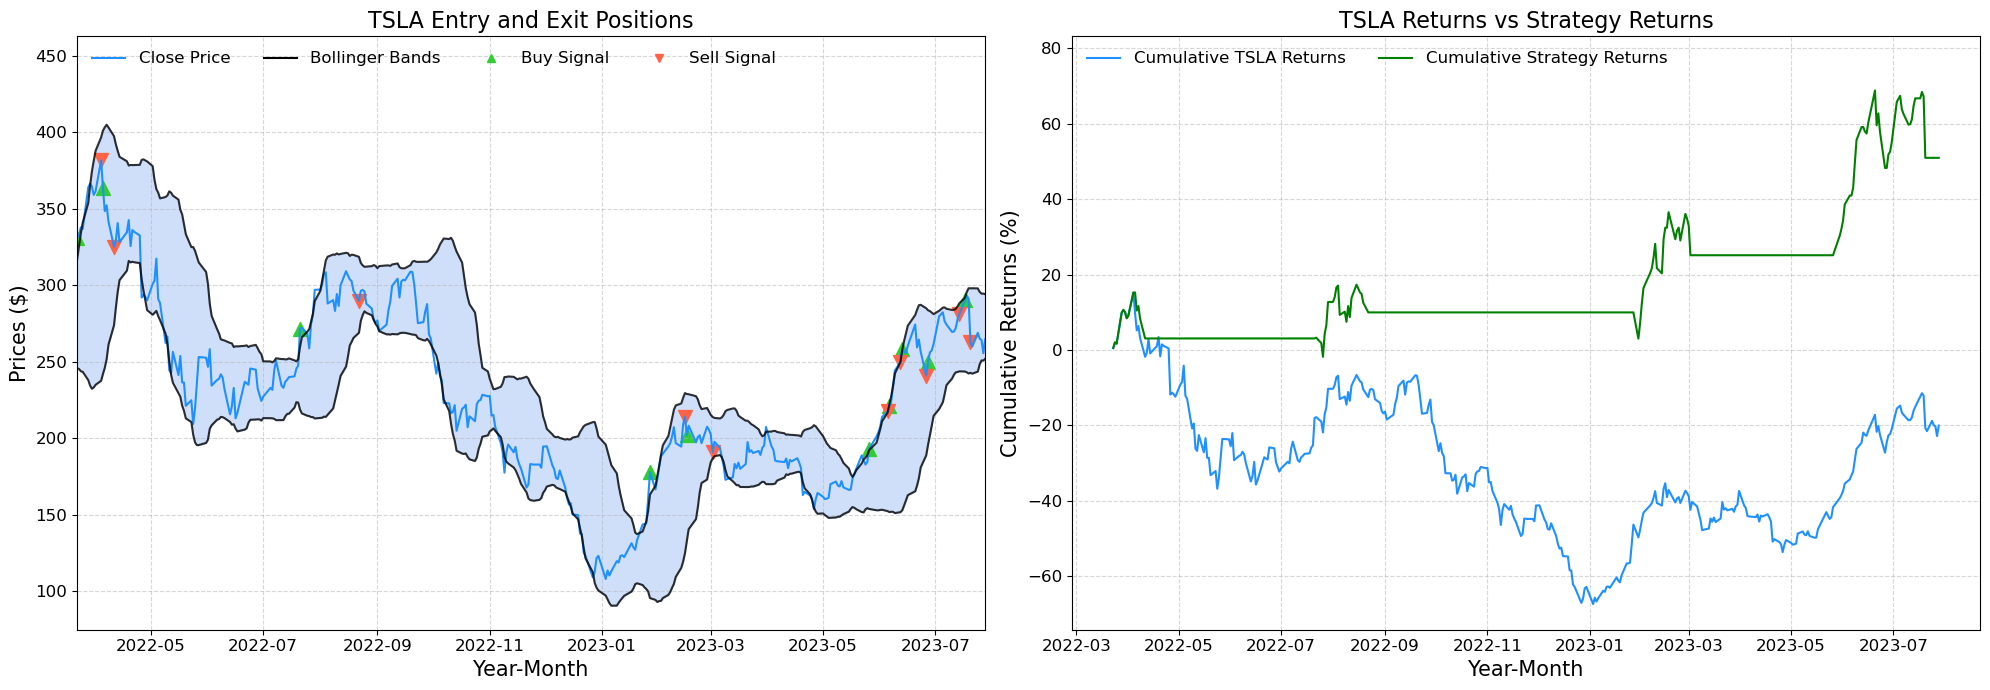

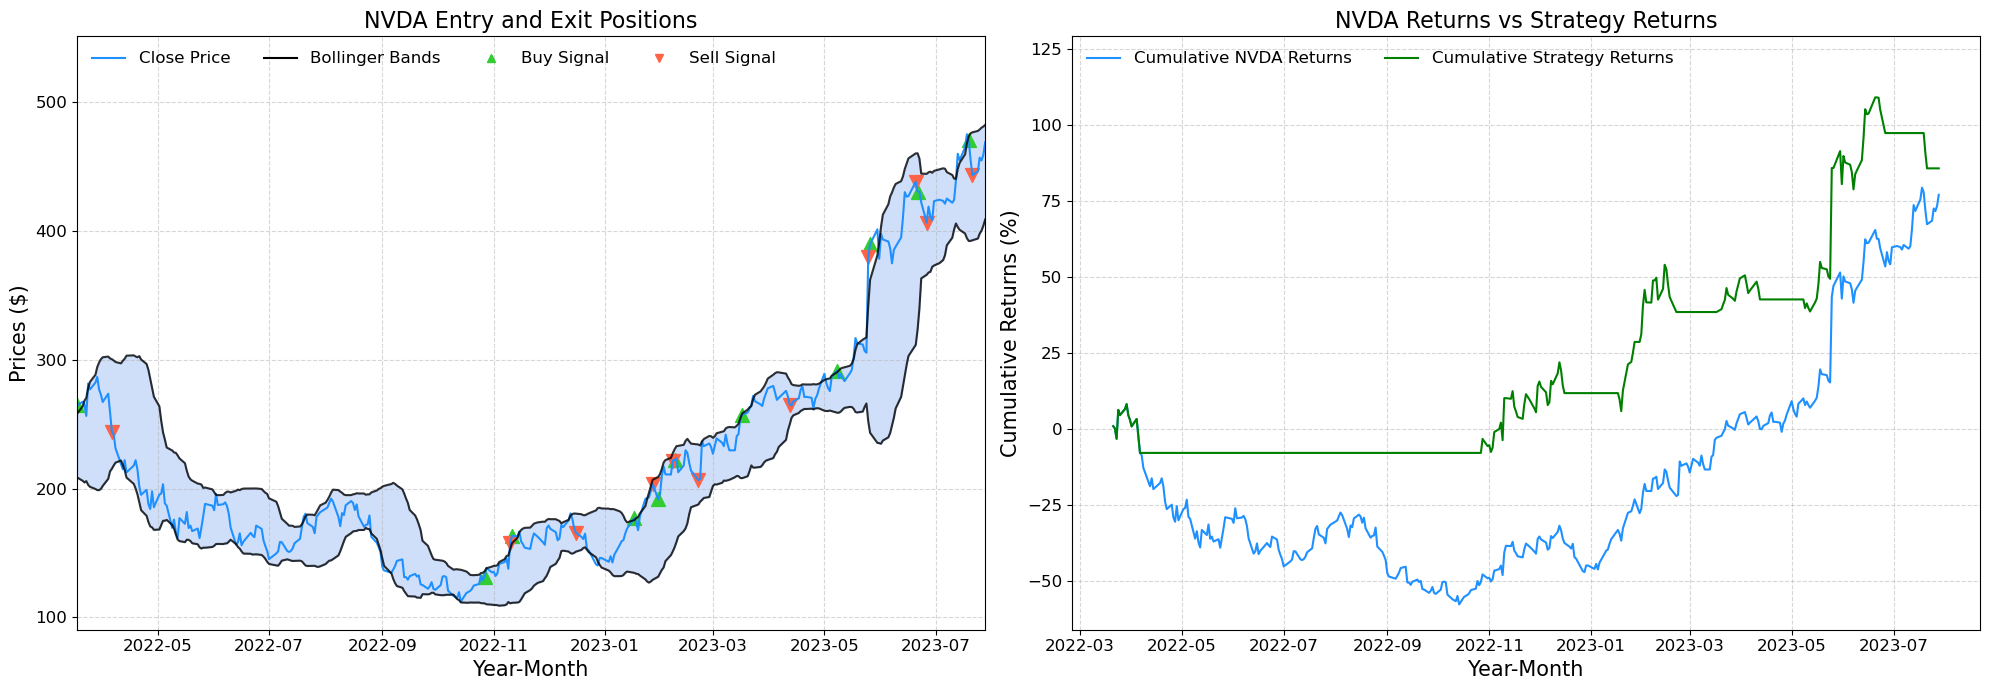

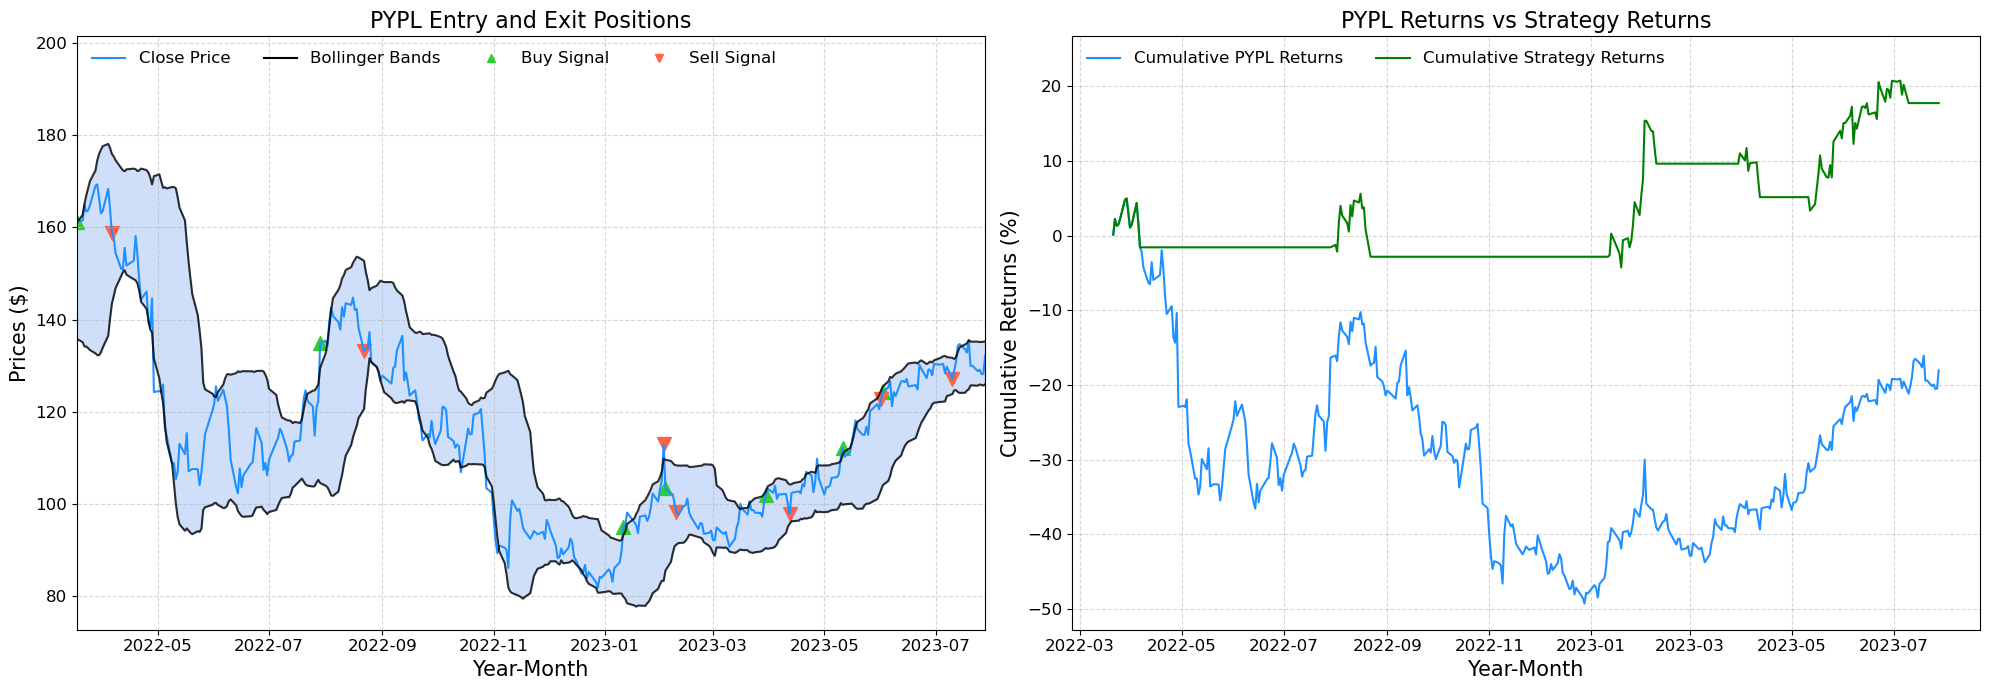

In [196]:
plot(tsla_data, 'TSLA')
plot(nvda_data, 'NVDA')
plot(pypl_data, 'AMZN')